In [2]:
from google.colab import files
# Upload file
uploaded = files.upload()

Saving augmented_ushealthinsurance.csv to augmented_ushealthinsurance.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb
import shap

In [4]:
# Load dataset
df = pd.read_csv("augmented_ushealthinsurance.csv")

# Display first few rows
df.head()

,age,sex,bmi,children,smoker,region,charges,User ID,Insurance Company,Feedback
0,19,female,27.900,0,yes,southwest,16884.92400,1,Company D,Good
1,18,male,33.770,1,no,southeast,1725.55230,2,Company E,Good
2,28,male,33.000,3,no,southeast,4449.46200,3,Company E,Terrible
3,33,male,22.705,0,no,northwest,21984.47061,4,Company A,Poor
4,32,male,28.880,0,no,northwest,3866.85520,5,Company C,Average


In [5]:
# Check for missing values
print(df.isnull().sum())

# Convert categorical columns to numerical
categorical_cols = ['sex', 'smoker', 'region', 'Insurance Company']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder for later inverse transform

# Normalize numerical columns
scaler = StandardScaler()
df[['age', 'bmi', 'children', 'charges']] = scaler.fit_transform(df[['age', 'bmi', 'children', 'charges']])

# Display processed dataset
df.head()


age                  0
sex                  0
bmi                  0
children             0
smoker               0
region               0
charges              0
User ID              0
Insurance Company    0
Feedback             0
dtype: int64


,age,sex,bmi,children,smoker,region,charges,User ID,Insurance Company,Feedback
0,-1.438764,0,-0.453320,-0.908614,1,3,0.298584,1,3,Good
1,-1.509965,1,0.509621,-0.078767,0,2,-0.953689,2,4,Good
2,-0.797954,1,0.383307,1.580926,0,2,-0.728675,3,4,Terrible
3,-0.441948,1,-1.305531,-0.908614,0,1,0.719843,4,0,Poor
4,-0.513149,1,-0.292556,-0.908614,0,1,-0.776802,5,2,Average


In [6]:
#4.1 Mapping Categories to Numerical Values

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define Feedback mapping
feedback_mapping = {
    "Terrible": 1,
    "Poor": 2,
    "Average": 3,
    "Good": 4,
    "Excellent": 5
}

# Apply feedback mapping to convert categorical feedback into numerical values
df['Feedback'] = df['Feedback'].map(feedback_mapping)

# Check for missing values
print(df.isnull().sum())

# Convert categorical columns to numerical
categorical_cols = ['sex', 'smoker', 'region', 'Insurance Company']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder for later inverse transform

# Normalize numerical columns
scaler = StandardScaler()
df[['age', 'bmi', 'children', 'charges']] = scaler.fit_transform(df[['age', 'bmi', 'children', 'charges']])

# Define the utility function
def calculate_utility(row):
    # Define weight parameters
    age_weight = 0.2
    bmi_weight = 0.2
    smoker_weight = 0.3
    feedback_weight = 0.3

    # Compute utility score
    utility_score = (
        age_weight * (1 - abs(row['age'])) +  # Younger users may have lower premiums
        bmi_weight * (1 - abs(row['bmi'])) +  # Healthy BMI preferred
        smoker_weight * (1 if row['smoker'] == 0 else -1) +  # Non-smokers get higher scores
        feedback_weight * (row['Feedback'] / 5.0)  # Normalize feedback (scale 1-5)
    )

    return utility_score

# Apply utility function to dataset
df['utility_score'] = df.apply(calculate_utility, axis=1)

# Display results
df[['User ID', 'Insurance Company', 'Feedback', 'utility_score']].head()


age                  0
sex                  0
bmi                  0
children             0
smoker               0
region               0
charges              0
User ID              0
Insurance Company    0
Feedback             0
dtype: int64


,User ID,Insurance Company,Feedback,utility_score
0,1,3,4,-0.038417
1,2,4,4,0.536083
2,3,4,1,0.523748
3,4,0,2,0.470504
4,5,2,3,0.718859


In [ ]:
#Step 4: User Feedback Integration

In [ ]:
#4.1 Mapping Feedback Categories to Numerical Values

In [8]:
# Define mapping for feedback categories
feedback_mapping = {
    "Terrible": 1,
    "Poor": 2,
    "Average": 3,
    "Good": 4,
    "Excellent": 5
}

# Simulating feedback column (random values for now)
np.random.seed(42)
df['feedback'] = np.random.choice(list(feedback_mapping.keys()), df.shape[0])

# Convert feedback to numerical values
df['feedback_score'] = df['feedback'].map(feedback_mapping)

# Display updated dataset
df[['age', 'bmi', 'smoker', 'charges', 'feedback', 'feedback_score']].head()

,age,bmi,smoker,charges,feedback,feedback_score
0,-1.438764,-0.453320,1,0.298584,Good,4
1,-1.509965,0.509621,0,-0.953689,Excellent,5
2,-0.797954,0.383307,0,-0.728675,Average,3
3,-0.441948,-1.305531,0,0.719843,Excellent,5
4,-0.513149,-0.292556,0,-0.776802,Excellent,5


In [ ]:
#Step 5: Utility-Based Recommendation System

In [11]:
def calculate_utility(row):
    # Define weight parameters
    age_weight = 0.2
    bmi_weight = 0.2
    smoker_weight = 0.3
    feedback_weight = 0.3

    # Compute utility score
    utility_score = (
        age_weight * (1 - abs(row['age'])) +  # Younger users may have lower premiums
        bmi_weight * (1 - abs(row['bmi'])) +  # Healthy BMI preferred
        smoker_weight * (1 if row['smoker'] == 0 else -1) +  # Non-smokers get higher scores
        feedback_weight * (row['Feedback'] / 5.0)  # Normalize feedback (assuming scale 1-5)
    )

    return utility_score

# Apply utility function to dataset
df['utility_score'] = df.apply(calculate_utility, axis=1)
df[['User ID', 'Insurance Company', 'utility_score']].head()

,User ID,Insurance Company,utility_score
0,1,3,-0.038417
1,2,4,0.536083
2,3,4,0.523748
3,4,0,0.470504
4,5,2,0.718859


In [13]:
## Apply utility function
df['Utility_Score'] = df.apply(calculate_utility, axis=1)

# Show top recommendations
df[['age', 'bmi', 'smoker', 'charges', 'feedback', 'Utility_Score']].sort_values(by="Utility_Score", ascending=False).head(10)

,age,bmi,smoker,charges,feedback,Utility_Score
505,-0.157143,0.034712,0,-0.534762,Terrible,0.961629
448,0.056461,-0.174444,0,-0.607946,Terrible,0.953819
1198,0.056461,-0.214635,0,-0.568075,Good,0.945781
1253,0.056461,-0.223658,0,0.211342,Good,0.943976
228,0.127662,0.159386,0,-0.488394,Average,0.942590
8,-0.157143,-0.136714,0,-0.567017,Average,0.941229
1104,-0.157143,-0.141635,0,0.590656,Average,0.940244
887,-0.228344,-0.105546,0,-0.660713,Excellent,0.933222
348,-0.228344,-0.121950,0,-0.643707,Poor,0.929941
873,0.270064,-0.092422,0,-0.530453,Good,0.927503


In [ ]:
#Step 2: Exploratory Data Analysis (EDA)

In [ ]:
#2.1 Feature Correlations

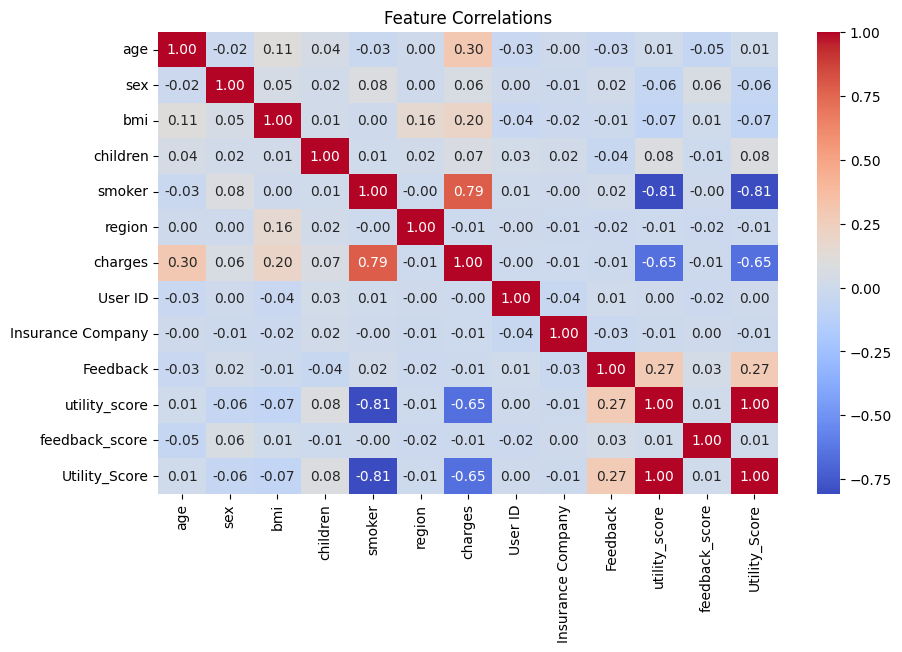

In [14]:
# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

In [ ]:
#Step 3: Data Visualization & Feature Relationships

In [ ]:
#3.1 Age vs Charges

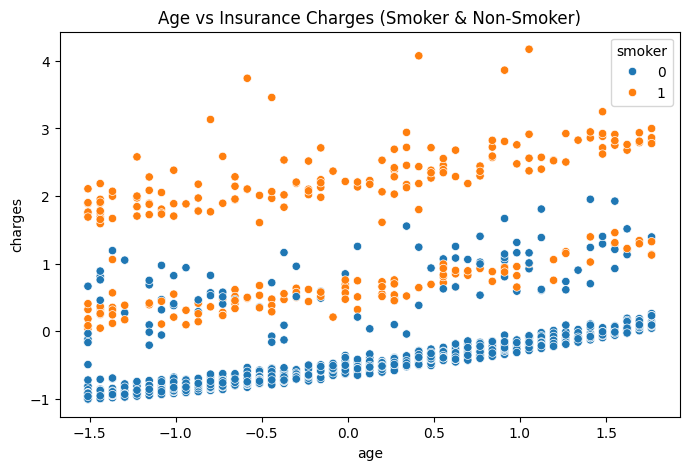

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["age"], y=df["charges"], hue=df["smoker"])
plt.title("Age vs Insurance Charges (Smoker & Non-Smoker)")
plt.show()

In [ ]:
#3.2 Smoker Impact on Charges

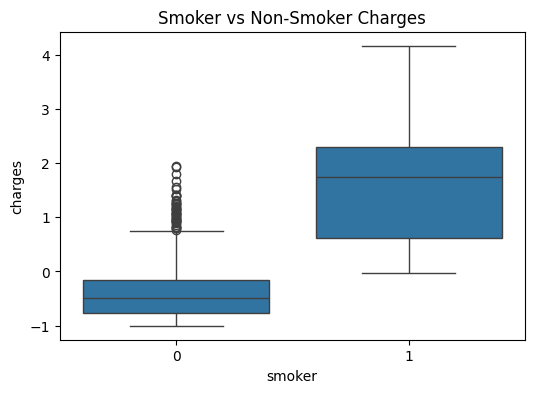

In [16]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoker"], y=df["charges"])
plt.title("Smoker vs Non-Smoker Charges")
plt.show()


In [ ]:
#Step 6: Machine Learning Model Training & Selection

In [ ]:
#6.1 Split Data

In [17]:
# Drop unnecessary columns
X = df.drop(columns=["charges", "Utility_Score", "feedback", "feedback_score", "Insurance Company"])

# Identify categorical columns that need encoding
categorical_cols = X.select_dtypes(include=['object']).columns

# Convert categorical variables using label encoding (if few categories)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Encode categorical columns
    label_encoders[col] = le  # Store encoders if needed later

# Define target variable
y = df["charges"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data processing complete. Ready for modeling!")

Data processing complete. Ready for modeling!


In [ ]:
##Train & Evaluate Models
#We will train four models and compare their performances.

In [18]:
from sklearn.linear_model import LinearRegression # Import LinearRegression

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate Model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr}, R²: {r2_lr}")

Linear Regression - MSE: 0.23012124320295582, R²: 0.7827833871242766


In [19]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")


Random Forest - MSE: 0.14798732665438574, R²: 0.8603114367149133


In [20]:
# Train XGBoost Model
from xgboost import XGBRegressor  # Import XGBRegressor explicitly
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb}, R²: {r2_xgb}")


XGBoost - MSE: 0.143406781835731, R²: 0.8646351159058696


In [21]:
# Train MLP (Neural Network) Model
from sklearn.neural_network import MLPRegressor  # Import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate Model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Regressor - MSE: {mse_mlp}, R²: {r2_mlp}")

MLP Regressor - MSE: 0.2247075874384363, R²: 0.7878934584591814


In [22]:
##Compare Model Performances


In [23]:
# Create DataFrame for model comparison
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "MLP Regressor"],
    "MSE": [mse_lr, mse_rf, mse_xgb, mse_mlp],
    "R² Score": [r2_lr, r2_rf, r2_xgb, r2_mlp]
})

# Sort by best performance
results_df.sort_values(by="MSE", ascending=True, inplace=True)

# Display results
print(results_df)

               Model       MSE  R² Score
2            XGBoost  0.143407  0.864635
1      Random Forest  0.147987  0.860311
3      MLP Regressor  0.224708  0.787893
0  Linear Regression  0.230121  0.782783


In [ ]:
#Visualize Model Performances

<ipython-input-24-805717ca6e36>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=results_df, palette="viridis")


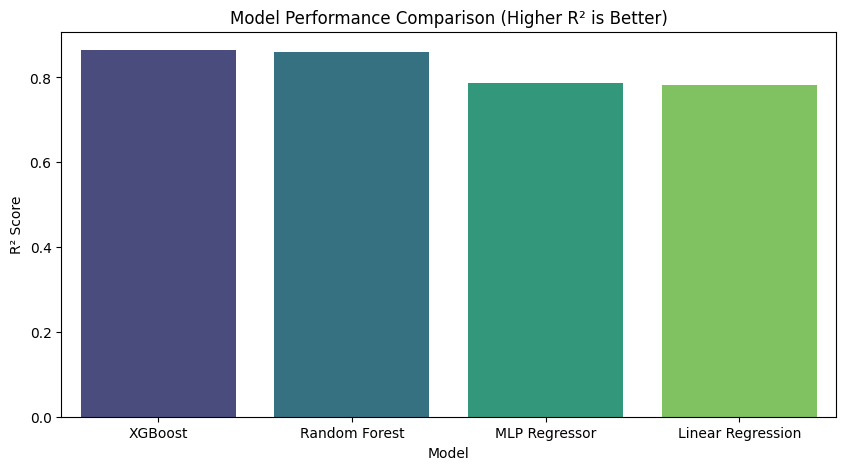

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="R² Score", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (Higher R² is Better)")
plt.show()

In [25]:
# Compare models
model_scores = {
    'Random Forest': {'MSE': mse_rf, 'R2 Score': r2_rf},
    'XGBoost': {'MSE': mse_xgb, 'R2 Score': r2_xgb},
    'MLP Regressor': {'MSE': mse_mlp, 'R2 Score': r2_mlp},
    'Linear Regression': {'MSE': mse_lr, 'R2 Score': r2_lr}
}

# Convert to DataFrame
scores_df = pd.DataFrame(model_scores).T
print(scores_df)

# Select best model based on MSE (lower is better)
best_model = min(model_scores, key=lambda x: model_scores[x]['MSE'])
print(f"🏆 Best Model: {best_model}")

                        MSE  R2 Score
Random Forest      0.147987  0.860311
XGBoost            0.143407  0.864635
MLP Regressor      0.224708  0.787893
Linear Regression  0.230121  0.782783
🏆 Best Model: XGBoost


In [ ]:
#Step 7: Explainability with SHAP (XAI)

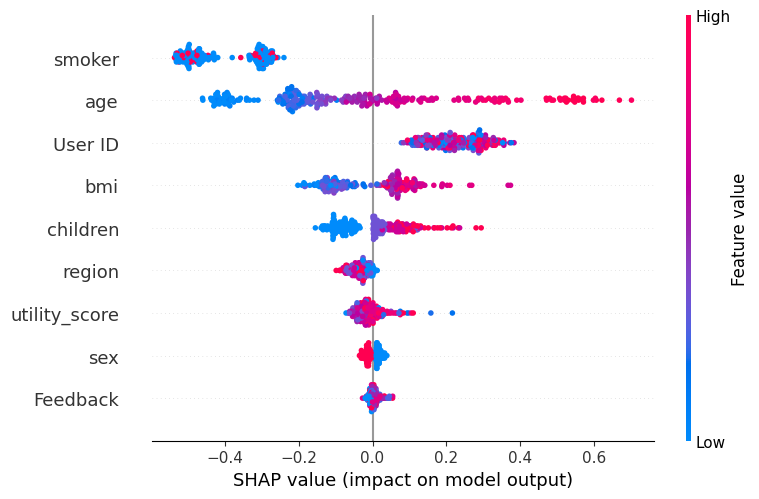

In [26]:
# Select the best model
final_model = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'MLP Regressor': mlp_model,
    'Linear Regression': lr_model
}[best_model]

# Ensure X_train and X_test are in the correct format (SHAP requires raw features)
X_train_shap = pd.DataFrame(scaler.inverse_transform(X_train), columns=X.columns)
X_test_shap = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)

# Choose SHAP explainer based on model type
if best_model in ['Random Forest', 'XGBoost']:
    explainer = shap.TreeExplainer(final_model)  # For tree-based models
elif best_model == 'MLP Regressor':
    explainer = shap.Explainer(final_model, X_train_shap)  # KernelExplainer for NN
else:
    explainer = shap.LinearExplainer(final_model, X_train_shap)  # For linear models

# Compute SHAP values
shap_values = explainer(X_test_shap)

# Summary Plot
shap.summary_plot(shap_values, X_test_shap)



In [28]:
final_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
#insurance recommendation_API

In [27]:
pip install fastapi uvicorn joblib scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00


In [30]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import xgboost as xgb
import lightgbm as lgb

app = FastAPI()

# Load dataset
df = pd.read_csv("augmented_ushealthinsurance.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ["sex", "smoker", "region", "Insurance Company", "Feedback"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=["User ID", "Insurance Company"])
y = df["Insurance Company"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (for SHAP consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Save models
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(lgb_model, "lgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Function to recommend insurance policies
def recommend_insurance(user_input):
    input_df = pd.DataFrame([user_input])

    # Ensure categorical encoding matches training data
    for col, le in label_encoders.items():
        if col in input_df:
            if input_df[col].values[0] in le.classes_:  # Handle unseen categories
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = -1  # Assign unseen categories a default value

    # Drop unnecessary columns
    input_df = input_df.drop(columns=["User ID"], errors='ignore')

    # Scale features
    input_df_scaled = scaler.transform(input_df)

    # Get predictions
    utility_scores = {
        "RandomForest": rf_model.predict_proba(input_df_scaled)[0],
        "XGBoost": xgb_model.predict_proba(input_df_scaled)[0],
        "LightGBM": lgb_model.predict_proba(input_df_scaled)[0],
    }

    # Find best recommendation
    best_model = max(utility_scores, key=lambda k: max(utility_scores[k]))
    best_recommendation = np.argmax(utility_scores[best_model])

    return label_encoders["Insurance Company"].inverse_transform([best_recommendation])[0], best_model

@app.post("/recommend")
def get_recommendation(user_input: dict):
    try:
        recommendation, model_used = recommend_insurance(user_input)
        return {"recommended_insurance": recommendation, "model_used": model_used}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

# SHAP Explainability
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

@app.get("/explain")
def explain_prediction():
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "SHAP Value": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values(by="SHAP Value", ascending=False)

    return feature_importance.to_dict(orient="records")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score -1.486476
[LightGBM] [Info] Start training from score -1.637876
[LightGBM] [Info] Start training from score -1.738972
[LightGBM] [Info] Start training from score -1.637876
[LightGBM] [Info] Start training from score -1.563768


In [ ]:
### or recommendation model/function

In [31]:
# Function to recommend insurance policies
def recommend_insurance(user_data):
    # Convert user input to DataFrame
    user_df = pd.DataFrame([user_data])

    # --- Apply feedback mapping to the user_df ---
    user_df['Feedback'] = user_df['Feedback'].map(feedback_mapping)

    # Encode categorical columns
    for col in categorical_cols:
        if col in label_encoders:  # Ensure encoder exists
            user_df[col] = user_df[col].map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)
        else:
            print(f"Warning: {col} was not in the training data!")

    # Normalize numerical columns (ensure correct shape)
    numeric_cols = ['age', 'bmi', 'children', 'charges']
    user_df[numeric_cols] = scaler.transform(user_df[numeric_cols])

    # Calculate utility score
    predicted_utility = calculate_utility(user_df.iloc[0])  # Using existing function

    # Recommend top 3 insurance companies based on highest utility scores
    recommendations = df[['Insurance Company', 'utility_score']].sort_values(by='utility_score', ascending=False).head(3)

    return predicted_utility, recommendations
